In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())



<br>

## Natural Language Processing
### :::: Long Short-Term Memory ::::

<br>

<br><br><br><br><br><br>


## Long-term dependencies

(Adapted from [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [here](https://arxiv.org/abs/1506.00019))

One of the expected advantages of Recurrent Neural Networks is the ability to capture long-range dependencies.

<br>

For example, consider the language modeling problem. Given a sentence like:

> “I grew up in <u>France</u> ... I speak fluent <u>French</u>.”

A trigram language model would have

$$p(\mathrm{French} \mid \mathrm{speak \: fluent}) \approx p(\mathrm{Spanish} \mid \mathrm{speak \: fluent})$$

But, given the presence of the word "France" earlier in the document, we should instead have that

$$p(\mathrm{French} \mid \mathrm{speak \: fluent}) >> p(\mathrm{Spanish} \mid \mathrm{speak \: fluent})$$

<br><br>
It is unscalable to capture such dependencies in a traditional language model or HMM.

Recall that the Viterbi algorithm takes time $O(S^2T)$, where $T$ is the length of the sequence and $S$ is the number of states.

A second-order Markov model conditions on the prior 2 states:

$p(q_i \mid q_{i-2} q_{i-1})$

- must consider 4 combinations of previous states (assuming binary state variables)


A third-order Markov model conditions on the prior 3 states:

$p(q_i \mid q_{i-3} q_{i-2} q_{i-1})$

- must consider 8 combinations of previous states (assuming binary state variables)

- $\rightarrow$ Viterbi complexity is exponential in the order of the model.
- Not to mention the data sparsity issue of fitting higher order probabilities $p(q_i \mid q_{i-3} q_{i-2} q_{i-1})$




<br><br>

## How do Recurrent Neural Networks encode long-range dependencies?

![char](figs/char.png)

$$
h_t = \mathrm{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)\\
y_t = W_{hy} h_t
$$
- input $x_t$
- hidden $h_t$
- output $y_t$

<br><br>

- Like a first-order HMM, Recurrent NNs only depend on the current input and the prior hidden state.
- However, the hidden state at time $t$ can contain information from an arbitrarily long context window
- How?
  - Given a hidden layer of $n$ binary nodes, how many distinct states can it encode?
    - $2^n$
  - Of course, our hidden nodes are in $\mathbf{R}$, we can represent even more states.
  
Thus, while the <u>expressive power</u> of the network grows exponentially with the number of hidden nodes, the complexity of <u>inference and training</u> grows at most quadratically.

<br>

$$
h_t=f(W_{xh}x_t + W_{hh} h_{t-1})
$$

$$
\begin{bmatrix}
h_{(t-1),1} \ldots h_{(t-1),k}
\end{bmatrix}
\begin{bmatrix}
W_{hh}[11] \ldots W_{hh}[1k]\\
\ldots\\
W_{hh}[k1] \ldots W_{hh}[kk]\\
\end{bmatrix}
$$

$$
O(k^2)
$$

![long](figs/long.png)



E.g., in the "French" example, if $x_1=\mathrm{France}$, and $x_{t+1} = \mathrm{French}$, our hope is that the hidden layer will retain information about "France" from $h_1$ up to $h_{t+1}$, influencing the prediction at time $t+1$.
<br>


<br><br>

## Vanishing / Exploding gradients

While the above explanation holds in theory, in practice there is an important limitation.

![vanish](figs/vanish.png)

- Recall that the weights are duplicated (shared) across time steps
  - e.g., $W_{hh}[i,j]$ is the transition weight from hidden node $i$ to hidden node $j$
- If the weight along a recurrent edge is less than 1, then the contribution of input at time $t$ on the hidden layer at time $t+m$ will decrease with $m$.
  - E.g., for three steps: $W_{hh}[i,j] * W_{hh}[i,j] * W_{hh}[i,j]$
- Conversely, if the weight is greater than 1, the contribution will increase over time.

<br>

**This contribution increase/decrease varies <u>exponentially</u> with m (the time gap)!**
  - E.g., for three steps, it's $W_{hh}[i,j]^3$
  
  


### Understanding vanishing gradients

To understand this phenomenon better, let's start with a simpler version of RNNs that ignores the input

$$
h_t = \mathrm{tanh}(W_{hh}h_{t-1})\\
y_t = W_{hy} h_t
$$

We'll consider sequences of increasing length and see what happens to $h_T$ for the final timestep $T$



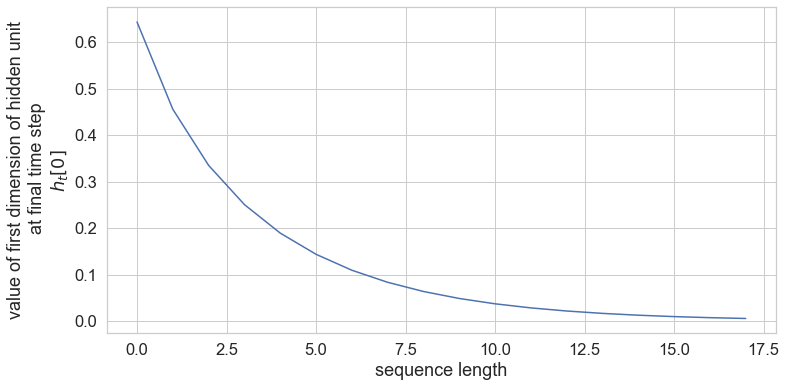

In [255]:
import torch
import torch.nn as nn

class RNNHidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(RNNHidden, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size, bias=False) # ignore bias for now
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        # ignoroing input
        # h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        h_new = self.tanh(self.hidden_to_hidden(h_prev))
        # y_h = softmax(W_hy h)
        output = self.softmax(self.hidden_to_output(h_new))
        if self.verbose: print('h_new\n', h_new, '\noutput\n',output, '\ntop output\n', output2label(output, chars))
        return output, h_new
    
    def forward_unrolled(self, x_list, hidden):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        Allows the initial hidden state to be passed in.
        """
        # hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hiddens
    
def output2label(output, chars):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return chars[top_i.item()] # , math.exp(top_n)

def char2vec(char, char2int):
    x = torch.zeros((1, len(char2int)))
    x[0][char2int[char]] = 1
    return x

def chars2vec(chars, char2int):
    return torch.cat([char2vec(c, char2int) for c in chars])

torch.random.manual_seed(42)
chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}
# let's use a single hidden unit
n_hidden = 1
rnn = RNNHidden(len(chars), n_hidden, len(chars), verbose=False)

optimizer = torch.optim.Adam(rnn.parameters(), lr=.1) 
criterion = nn.BCELoss()

# create sequences of increasing size and call forward_unrolled
hidden_vals = []
for seq_len in range(2,20):
    optimizer.zero_grad() # reset all the gradient information
    x = chars2vec('a'*seq_len, char2int)
    hidden = torch.ones(1, n_hidden)
    outputs, hiddens = rnn.forward_unrolled(x, hidden)
    # store the first dimension of the final hidden state
    hidden_vals.append(hiddens[-1][0].item())
    loss = criterion(outputs[-1], x[-1])
    loss.backward()

# print(rnn.hidden_to_hidden.weight.grad)
plt.figure()
plt.plot(hidden_vals)
plt.xlabel('sequence length')
plt.ylabel('value of first dimension of hidden unit\n at final time step\n$h_t[0]$')
plt.show()


$$
h_t = \mathrm{tanh}(W_{hh}h_{t-1})\\
$$

if $|h|=1$ (single hidden cell), and $W_{hh} = [.76]$, then

$$
h_t = \mathrm{tanh}(.76 * h_{t-1})
$$

What happens when we compute this for large $t$?

In [182]:
rnn.hidden_to_hidden.weight

Parameter containing:
tensor([[0.7645]], requires_grad=True)

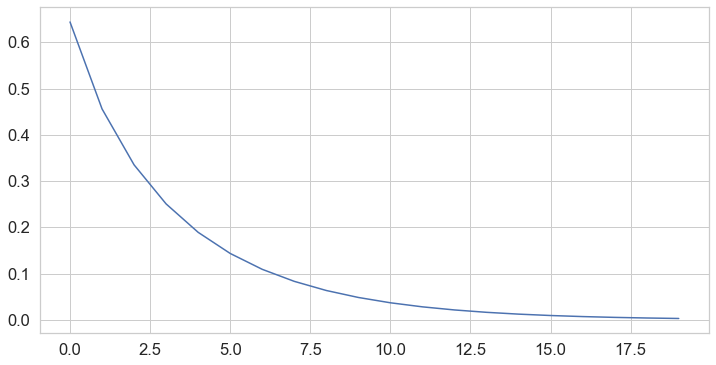

In [258]:
import math

vals = []
val = 1 # initial hidden value
for i in range(20):
    val = np.tanh(.7645*val)
    vals.append(val)
plt.figure()
plt.plot(vals)
plt.show()

Consider our example:

> “I grew up in <u>France</u> ... I speak fluent <u>French</u>.”

Somehow we need to "remember" *France* until we get to *French*. 

But, the graph above shows there is exponential decay in the value of a hidden unit over time.

So, if the hidden unit at time $1$ represents *France*, it cannot maintain that value very long.


<br><br>
An analogous problem exists in the backward direction. 

Consider how the gradient with respect to a single output affects earlier hidden units.

E.g., at training time, if we predict "Spanish" instead of "French", we need to somehow updated the hidden unit produced by "France" many steps prior.


![figs/bpt.png](figs/bpt.png)

Recall [backpropagation equation](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/neural.ipynb) for simple neural network. It uses the chain rule in calculus:

$$
f(x) = g(h(x))\\
f'(x) = g'(h(x)) \cdot h'(x)
$$

$$
y_3 = W_{hy} h_3\\
h_3 = \mathrm{tanh}(W_{hh}h_{2})\\
h_2 = \mathrm{tanh}(W_{hh}h_{1})\\
$$

$$
y_3 = W_{hy} \cdot \mathrm{tanh}(W_{hh} \cdot \mathrm{tanh}(W_{hh} \cdot h_1)))
$$


$$
\frac{\partial y_3}{\partial h_1} = \frac{\partial y_3}{\partial h_3}\frac{\partial h_3}{\partial h_2}\frac{\partial h_2}{\partial h_1}
$$

- Just like in the forward pass, we end up with a chain of multiplications that exponentially decays to 0

<br><br><br>
So, how can we pass information in the hidden state forward/backward over long distances?

<br><br><br>

It would be nice if we could somehow just copy a part of the hidden state forward without requiring a multiplication.


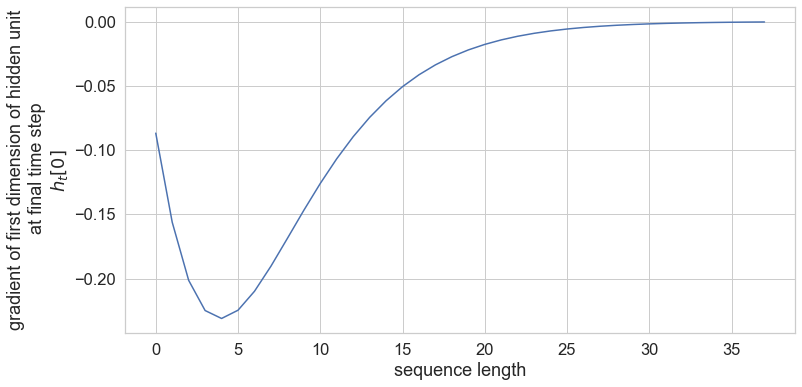

In [267]:
# create sequences of increasing size and call forward_unrolled
gradient_vals = []
for seq_len in range(2,40):
    optimizer.zero_grad() # reset all the gradient information
    x = chars2vec('a'*seq_len, char2int)
    hidden = torch.ones(1, n_hidden)
    outputs, hiddens = rnn.forward_unrolled(x, hidden)
    # compute loss based on just the final output at time T
    loss = criterion(outputs[-1], x[-1])
    loss.backward()
    gradient_vals.append(rnn.hidden_to_hidden.weight.grad.item())
plt.figure()
plt.plot(gradient_vals)
plt.xlabel('sequence length')
plt.ylabel('gradient of first dimension of hidden unit\n at final time step\n$h_t[0]$')
plt.show()

<br>
One simple hack:

> Clip weights to $w_{min} \le W_{hh} \le w_{max}$

e.g., $w_{min}=-5$, $w_{max}=5$

<Br><br>
    
But, doing so hampers the ability of the network to learn long-range dependencies.
  - The size of the clip parameters affects the memory size of the network.

## Long short-term memory (LSTM)

The idea of LSTMs is to introduce a <u>memory cell</u>:
  - a state that stores the information from prior steps
  - explicitly allows remembering and forgetting of prior state information
  - by altering the transition function, we can ensure that the gradient does not explode/vanish over time.


<br><br>

Where does the name come from?
- **Long-term memory**: The parameters of the model, which are shared across time steps, are analogous to long-term memory.
- **Short-term memory**: The hidden layers represent short-term memory, since they can change as new input is read.


<br><br>

Consider a traditional recurrent neural network:

![rnn](figs/rnn.png)

An LSTM makes several changes:
![lstm](figs/lstm1.png)

![notation](figs/notation.png)


#### Cell State ($C_t$)

The core idea of LSTM is to introduce a cell state $C_t$ (a memory cell)

![cellstate](figs/cellstate.png)

We'll see below that the cell state $C_t$ is a simpler linear function of the prior cell state $C_{t-1}$, which is what prevents the vanishing gradient problem. 

There are several gates that will decide what information is included in the cell state.

#### Forget Gate Layer

![forget](figs/forget.png)

Note shorthand: $W_f \cdot[h_{t-1}, x_t] = W_{fh} h_{t-1} + W_{fx}x_t$

The forget gate outputs a number between 0 and 1 for each number in the cell state $C_{t−1}$.
  - 1 means keep this number
  - 0 means forget this number
  
E.g., in "French" example, 1 means keep the information about "France" in the cell state, so it can be used later to predict the term "French."



#### Input Gate 

![input](figs/input.png)

The input gate layer decides what new information to add to the memory cell.  
- First, a sigmoid layer called the “input gate layer” decides which values we’ll update.
- Next, a tanh layer creates a vector of new candidate values, $\tilde{C}_t$, that could be added to the state.


#### Updating the Cell State

![update](figs/update.png)

To create the new state, we:
- Multiply the old state by $f_t$, forgetting the things we decided to forget earlier.
- Then we add $i_t*\tilde{C}_t$; this is the new candidate values, scaled by how much we decided to update each state value.
  - Note that the "*" notation here is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))
  
$$
\begin{bmatrix}
1 & 2\\
3 & 4\\
\end{bmatrix}
*
\begin{bmatrix}
1 & 2\\
3 & 4\\
\end{bmatrix}
=
\begin{bmatrix}
1 & 4\\
9 & 16\\
\end{bmatrix}
$$

#### Output Gate

![output](figs/output.png)

- Similar to the output of recursive NN, but filtered
- First, apply a sigmoid layer to decide which parts of the memory cell state to output.
- Then, apply a tanh layer (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the chosen parts.

<br>

Note: if we just used $f_t=1$ for all $t$, we would just remember all cell states, without forgetting any information.
- This would already solve the diminishing gradient problem.
- The forgetting allows for a sparser, more efficient model.

$$
\begin{align}
\hbox{hidden state}~~~ h_t & = & o_t * \mathrm{tanh}(C_t)\\
\hbox{memory cell}~~~ C_t & = & f_t * C_{t-1} + i_t * \tilde{C}_t \\
\hbox{candidate additions}~~~ \tilde{C}_t & = & \mathrm{tanh}(W_{Ch} h_{t-1} + W_{Cx} x_t)\\
\hbox{output gate}~~~ o_t & = & \sigma (W_{oh} h_{t-1} + W_{ox} x_t)\\
\hbox{forget gate}~~~ f_t & = & \sigma(W_{fh} h_{t-1} + W_{fx} x_t)\\
\hbox{input gate}~~~ i_t & = & \sigma(W_{ih} h_{t-1} + W_{ix} x_t)
\end{align}
$$

In [412]:
import torch
import torch.nn as nn
from tqdm import tqdm

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(LSTM, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # input gate
        self.W_ih = nn.Linear(hidden_size, hidden_size)
        self.W_ix = nn.Linear(input_size, hidden_size)
        # forget gate
        self.W_fh = nn.Linear(hidden_size, hidden_size)
        self.W_fx = nn.Linear(input_size, hidden_size)
        # output gate
        self.W_oh = nn.Linear(hidden_size, hidden_size)
        self.W_ox = nn.Linear(input_size, hidden_size)
        # memory cell
        self.W_ch = nn.Linear(hidden_size, hidden_size)
        self.W_cx = nn.Linear(input_size, hidden_size)
        # prediction
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, x, h_prev, c_prev):
        in_gate = torch.sigmoid(self.W_ih(h_prev) + self.W_ix(x))
        forget_gate = torch.sigmoid(self.W_fh(h_prev) + self.W_fx(x))
        output_gate = torch.sigmoid(self.W_oh(h_prev) + self.W_ox(x))
        cell_gate = self.tanh(self.W_ch(h_prev) + self.W_cx(x))
        
        c_new = forget_gate * c_prev + in_gate * cell_gate
        h_new = output_gate * torch.tanh(c_new)
        
        output = self.softmax(self.hidden_to_output(h_new))
        
        if self.verbose: 
            display(pd.DataFrame([{'h_new:': h_new.detach().cpu().numpy()[0],
                               'c_new:': c_new.detach().cpu().numpy()[0],
                               'in:': in_gate.detach().cpu().numpy()[0],
                               'forget:': forget_gate.detach().cpu().numpy()[0],
                               'output_gate:': output_gate.detach().cpu().numpy()[0],
                               'cell:': cell_gate.detach().cpu().numpy()[0],
                               'output:': output.detach().cpu().numpy()[0],
                               'top output:':  output2label(output, chars)}]).transpose())
        return output, h_new, c_new
    
    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        cell = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        cells = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden, cell = self.forward(x, hidden, cell)
            outputs.append(output)
            hiddens.append(hidden)
            cells.append(cell)
        return torch.cat(outputs), hiddens, cells
    
def output2label(output, chars):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return chars[top_i.item()] # , math.exp(top_n)

def train_model(model, data, epochs=20, learning_rate=0.1):
    torch.random.manual_seed(42)  # for reproducibility
    np.random.seed(42)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate) 
    model.verbose = False
    loss_val = []
    # main training loop
    for epoch in tqdm(range(epochs), total=epochs):
        np.random.shuffle(data)
        for datum in data:
            # optimizing after each instance
            optimizer.zero_grad() # reset all the gradient information
            result = model.forward_unrolled(datum)
            loss = criterion(result[0], datum[1:])
            loss.backward()      # computes all the gradients
            optimizer.step()     # update parameters
            loss_val.append(loss.item())

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('instances')
    plt.show()
    return model



torch.random.manual_seed(42)
chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}

x = char2vec('c', char2int)
n_hidden = 3
lstm = LSTM(len(chars), n_hidden, len(chars), verbose=True)
output, hidden, cell = lstm.forward(x, torch.zeros(1, n_hidden), torch.zeros(1, n_hidden))

,0
h_new:,"[0.064341344, 0.02615455, -0.03919616]"
c_new:,"[0.14204024, 0.03734128, -0.10838544]"
in:,"[0.44698095, 0.58726555, 0.55602556]"
forget:,"[0.47671592, 0.49731252, 0.6886509]"
output_gate:,"[0.45602196, 0.7007447, 0.36305174]"
cell:,"[0.31777695, 0.063585006, -0.19492888]"
output:,"[0.3500837, 0.29164618, 0.35827014]"
top output:,c


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


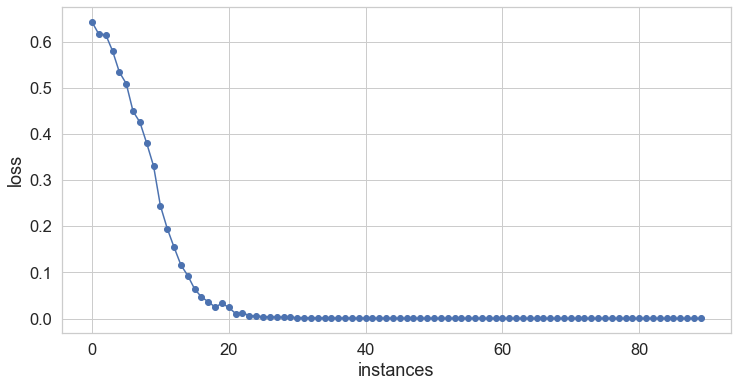

In [413]:

data = [
    chars2vec('abcabcabc', char2int),
    chars2vec('bcabcabca', char2int),
    chars2vec('cabcabcab', char2int)
]  * 10

lstm = train_model(lstm, data, epochs=3, learning_rate=.1)

In [415]:
lstm.verbose=True
x = chars2vec('abc', char2int)
outputs, _, _ = lstm.forward_unrolled(x)

,0
h_new:,"[-0.742594, -0.7564507, 0.75178844]"
c_new:,"[-0.9662197, -0.99031323, 0.98332477]"
in:,"[0.9900563, 0.99680245, 0.99473023]"
forget:,"[0.014937596, 0.017928507, 0.43499842]"
output_gate:,"[0.9940507, 0.9986203, 0.99640405]"
cell:,"[-0.975924, -0.99349, 0.9885341]"
output:,"[0.00023713487, 0.9987118, 0.0010510596]"
top output:,b


,0
h_new:,"[0.690608, -0.96142703, -0.7589058]"
c_new:,"[0.9783816, -1.9672575, -0.9985933]"
in:,"[0.99337405, 0.99863225, 0.9994886]"
forget:,"[0.012892401, 0.9792839, 0.00090672297]"
output_gate:,"[0.91791683, 0.9997788, 0.9972446]"
cell:,"[0.9974475, -0.9988258, -0.9999963]"
output:,"[0.00032778643, 0.00024695022, 0.9994253]"
top output:,c


100%|██████████| 3/3 [00:00<00:00, 13.73it/s]


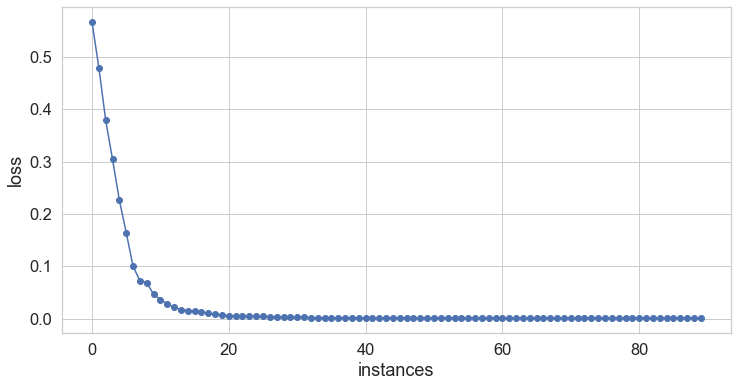

,0
h_new,"[0.8890203, 0.9266685, -0.9657477]"
output,"[3.41769e-05, 0.99941623, 0.0005496377]"
top output,b


,0
h_new,"[0.99868816, -0.9999051, 0.99351776]"
output,"[0.0009131078, 7.080227e-05, 0.99901605]"
top output,c


tensor([[3.4177e-05, 9.9942e-01, 5.4964e-04],
        [9.1311e-04, 7.0802e-05, 9.9902e-01]], grad_fn=<CatBackward>)


In [419]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(RNN, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_xh
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        # y_h = softmax(W_hy h)
        output = self.softmax(self.hidden_to_output(h_new))
        
        if self.verbose: 
            display(pd.DataFrame([{
                'h_new': h_new.detach().cpu().numpy()[0],
                'output': output.detach().cpu().numpy()[0],
                'top output': output2label(output, chars)}]).transpose())
        return output, h_new
    
    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hiddens

rnn = RNN(len(chars), n_hidden, len(chars), verbose=True)
rnn = train_model(rnn, data, epochs=3, learning_rate=.1)

rnn.verbose=True
x = chars2vec('abc', char2int)
outputs, _  = rnn.forward_unrolled(x)
print(outputs)

How can we compare the "memory" abilities of LSTM vs RNN?

100%|██████████| 30/30 [00:03<00:00,  8.09it/s]


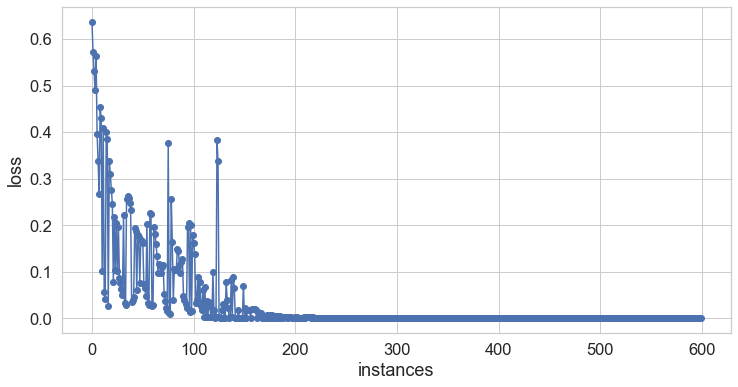

,0
h_new:,"[0.5625536, 0.028493261, 0.21186471, 0.14375302, -0.49868765, 0.23433687, 0.723558, -0.72287613,..."
c_new:,"[0.97206247, 0.03606089, 0.4384539, 0.26479027, -0.7825956, 0.39092165, 0.94272697, -0.99368113,..."
in:,"[0.9776859, 0.038748015, 0.5296966, 0.36359254, 0.81979114, 0.5406206, 0.9806198, 0.99490523, 0...."
forget:,"[0.846426, 0.8527102, 0.67396307, 0.4778236, 0.21510516, 0.04936247, 0.49774206, 0.36683306, 0.3..."
output_gate:,"[0.7504625, 0.79048556, 0.5137832, 0.5555231, 0.7622932, 0.6296763, 0.98246413, 0.9524968, 0.247..."
cell:,"[0.9942482, 0.93065125, 0.8277454, 0.728261, -0.954628, 0.7230979, 0.9613583, -0.99876964, 0.849..."
output:,"[0.00011190226, 0.99966955, 0.00021860728]"
top output:,b


,0
h_new:,"[0.02728482, 0.014438999, -0.5532884, -0.6212964, -0.7849058, -0.7388845, 0.14232105, -0.0242493..."
c_new:,"[1.9031339, 0.03159387, -0.6248394, -0.7328768, -1.060727, -0.965386, 0.15639207, -0.8448491, 0...."
in:,"[0.9802096, 0.010528142, 0.99054575, 0.9882514, 0.9944999, 0.9706662, 0.10995164, 0.8239694, 0.0..."
forget:,"[0.9512508, 0.88785803, 0.8321045, 0.949647, 0.08462497, 0.013243867, 0.07184462, 0.023381162, 0..."
output_gate:,"[0.028525539, 0.45717105, 0.9978356, 0.99435717, 0.9986816, 0.98957354, 0.91743445, 0.03522732, ..."
cell:,"[0.9982138, -0.040185496, -0.9991248, -0.9960361, -1.0, -0.99989396, 0.8063746, -0.99714345, 0.9..."
output:,"[4.4733362e-05, 0.00013495197, 0.9998203]"
top output:,c


,0
h_new:,"[0.89940864, 0.010675699, -0.06225887, -0.023911359, -0.63450426, 0.69884664, 0.80959773, -0.933..."
c_new:,"[2.8756108, 0.01123267, -1.2786993, -0.30694053, -0.7502664, 0.95228416, 1.1302955, -1.8281057, ..."
in:,"[0.9941024, 0.02517341, 0.84745544, 0.15784378, 0.9940545, 0.9566521, 0.98772675, 0.9891964, 0.9..."
forget:,"[0.98895186, 0.9896881, 0.6944346, 0.27034822, 0.0065635215, 0.0026235988, 0.9321909, 0.99296993..."
output_gate:,"[0.9051451, 0.95045507, 0.0727206, 0.08033348, 0.99873513, 0.9433479, 0.99812275, 0.9826158, 0.9..."
cell:,"[0.999397, -0.79589564, -0.9968538, -0.6893436, -0.74775, 0.9980817, 0.99674153, -0.99999946, -0..."
output:,"[7.624034e-05, 0.9999075, 1.6196058e-05]"
top output:,b


,0
h_new:,"[0.00060398097, -0.03072746, -0.9700851, -0.85968834, -0.7694673, -0.75468844, -0.030337201, -0...."
c_new:,"[3.698683, -0.037934475, -2.1095927, -1.2978632, -1.0199467, -0.9868329, -0.030770034, -0.919465..."
in:,"[0.9790385, 0.04975295, 0.9945787, 0.9971999, 0.9971456, 0.99252033, 0.12462689, 0.96037525, 0.0..."
forget:,"[0.946432, 0.9912486, 0.8723717, 0.980166, 0.030390695, 0.0059184567, 0.07742223, 0.008557158, 0..."
output_gate:,"[0.0006047218, 0.81040263, 0.99905235, 0.99827707, 0.9995096, 0.99825376, 0.9862445, 0.004974222..."
cell:,"[0.99803334, -0.98625, -0.9995103, -0.99981016, -1.0, -0.99994826, -0.9490732, -0.9411133, 0.987..."
output:,"[9.362957e-06, 2.8197326e-06, 0.99998784]"
top output:,c


,0
h_new:,"[0.9210289, -0.09666803, -0.018106528, -0.012700639, 0.58357334, 0.7233155, 0.7364543, -0.950339..."
c_new:,"[4.6606064, -0.098056994, -2.4932847, -0.43091568, 0.6688086, 0.9786346, 0.94377506, -1.9134932,..."
in:,"[0.9958116, 0.0644495, 0.83420724, 0.11258617, 0.9950074, 0.98022604, 0.9970739, 0.9958073, 0.97..."
forget:,"[0.99091315, 0.9975821, 0.7872725, 0.2622447, 0.0025791617, 0.0014976785, 0.9757337, 0.99806553,..."
output_gate:,"[0.9211938, 0.98899275, 0.01835553, 0.031275716, 0.9989348, 0.9612495, 0.9993248, 0.9926483, 0.9..."
cell:,"[0.99971974, -0.9342857, -0.997906, -0.8043432, 0.6748082, 0.99988425, 0.9766562, -0.9999993, -0..."
output:,"[0.001075543, 0.9989222, 2.2976662e-06]"
top output:,b


,0
h_new:,"[0.00016452387, -0.6400539, -0.99703515, -0.8898712, -0.73960626, -0.7526499, -0.56773406, 0.004..."
c_new:,"[5.0651894, -0.80712444, -3.390407, -1.4236948, -0.9554392, -0.9824196, -0.6716823, 0.98300153, ..."
in:,"[0.9364007, 0.71333724, 0.9946278, 0.9986731, 0.99179876, 0.99679875, 0.7102046, 0.9876867, 0.04..."
forget:,"[0.8877282, 0.9986885, 0.9613926, 0.9865129, 0.05436102, 0.014630057, 0.040746905, 0.0009957568,..."
output_gate:,"[0.00016453698, 0.9581633, 0.9993017, 0.9994429, 0.9964575, 0.99806195, 0.96868837, 0.0059740315..."
cell:,"[0.9908549, -0.9941946, -0.99874735, -0.9999178, -0.99999756, -0.99993813, -0.9999065, 0.9971856..."
output:,"[0.00020430039, 6.525331e-07, 0.999795]"
top output:,c


,0
h_new:,"[0.12862661, -0.8952282, -0.013732414, -0.018618677, 0.7581563, 0.7497493, -0.91664624, -0.01853..."
c_new:,"[5.975269, -1.4499153, -3.7156074, -0.5086727, 0.9935013, 0.99110264, -1.5680681, -0.018995881, ..."
in:,"[0.99157965, 0.6440484, 0.83669, 0.17385569, 0.9956624, 0.9934155, 0.9998597, 0.9997404, 0.99557..."
forget:,"[0.98406017, 0.9998561, 0.8502558, 0.24495141, 0.0020765676, 0.002295899, 0.9855187, 0.9975955, ..."
output_gate:,"[0.12862828, 0.9994999, 0.013748695, 0.039706256, 0.9990841, 0.9893343, 0.9999218, 0.97568697, 0..."
cell:,"[0.99923134, -0.9982277, -0.99546325, -0.919939, 0.9998222, 0.99994236, -0.9062398, -0.99989337,..."
output:,"[0.99860185, 0.0011193951, 0.00027881865]"
top output:,a


In [435]:
pd.set_option('display.max_colwidth', 100)
data = [
    chars2vec('abcbcbca', char2int),
    chars2vec('bcbcbcbc', char2int),
]  * 10

lstm = LSTM(len(chars), 10, len(chars), verbose=True)
lstm = train_model(lstm, data, epochs=30, learning_rate=.05)

lstm.verbose=True
x = chars2vec('abcbcbca', char2int)
outputs, _, _ = lstm.forward_unrolled(x)

100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


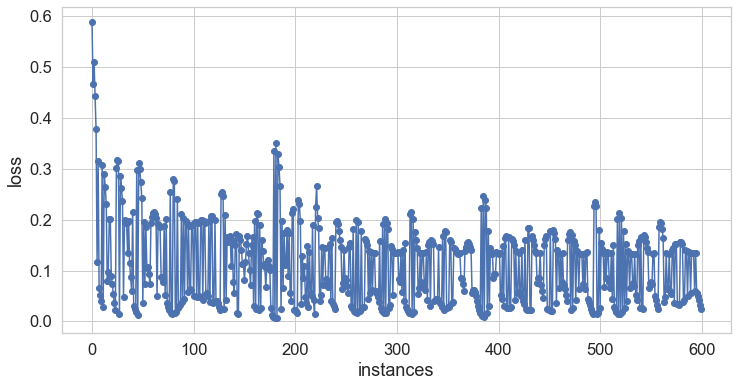

,0
h_new,"[0.9904844, 0.8831415, 0.9515847, -0.9970378, 0.9296101, 0.56504524, -0.8579373, 0.9831153, -0.9..."
output,"[9.2959584e-05, 0.9997725, 0.00013460286]"
top output,b


,0
h_new,"[-0.79062545, -0.9954779, 0.99999994, 0.99943435, -0.999175, 0.9986862, 0.9999998, -0.99998397, ..."
output,"[5.625312e-07, 8.911888e-09, 0.9999994]"
top output,c


,0
h_new,"[0.9999999, 0.9957787, -0.9999988, -1.0, 0.99999833, 1.0, -1.0, 1.0, -1.0, 0.9999941]"
output,"[0.0013077204, 0.99869233, 1.6631548e-08]"
top output,b


,0
h_new,"[-0.9999979, 0.9248468, 1.0, 0.9999911, -0.9999995, -0.999978, 0.9999999, -0.9999999, 1.0, -1.0]"
output,"[2.260804e-06, 1.430011e-06, 0.9999963]"
top output,c


,0
h_new,"[0.9999993, -0.99998695, -0.9999999, -0.9999999, 0.99999994, 0.99999964, -0.99997, 1.0, -1.0, 1.0]"
output,"[0.16871688, 0.83127993, 3.214614e-06]"
top output,b


,0
h_new,"[-0.99981314, 0.99986464, 1.0, 0.99981755, -0.99999976, -0.9995336, 0.9999976, -0.9999836, 1.0, ..."
output,"[2.2954991e-06, 1.755839e-06, 0.99999595]"
top output,c


,0
h_new,"[0.99999917, -0.9999897, -0.9999999, -0.9999999, 0.99999994, 0.99999964, -0.9999667, 1.0, -1.0, ..."
output,"[0.16871883, 0.831278, 3.2146556e-06]"
top output,b


tensor([[9.2960e-05, 9.9977e-01, 1.3460e-04],
        [5.6253e-07, 8.9119e-09, 1.0000e+00],
        [1.3077e-03, 9.9869e-01, 1.6632e-08],
        [2.2608e-06, 1.4300e-06, 1.0000e+00],
        [1.6872e-01, 8.3128e-01, 3.2146e-06],
        [2.2955e-06, 1.7558e-06, 1.0000e+00],
        [1.6872e-01, 8.3128e-01, 3.2147e-06]], grad_fn=<CatBackward>)


In [434]:
rnn = RNN(len(chars), 10, len(chars), verbose=True)
rnn = train_model(rnn, data, epochs=30, learning_rate=.05)

rnn.verbose=True
x = chars2vec('abcbcbca', char2int)
outputs, _  = rnn.forward_unrolled(x)
print(outputs)

#### sources
- https://arxiv.org/abs/1506.00019
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://github.com/nicodjimenez/lstm
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [1]:
from IPython.core.display import HTML
HTML(open('../custom.css').read())